<a href="https://colab.research.google.com/github/dinghengm/scaling/blob/main/BE537_python1_YiQi_DinghengMai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***This assignment is collaborated by Yi Qi and Dingheng Mai.*** 

In [ ]:
# Import required libraries
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy
from scipy import interpolate, signal
from scipy.interpolate import interpn
# Configure matplotlib options
import matplotlib
%matplotlib inline 
matplotlib.rcParams['figure.figsize'] = [12, 8]

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_dir= '/content/drive/My Drive/BE537/hw1/data/'

Mounted at /content/drive


## **3.3 Explore the Data in ITK-SNAP**

### **3.3.1 Deliverables**

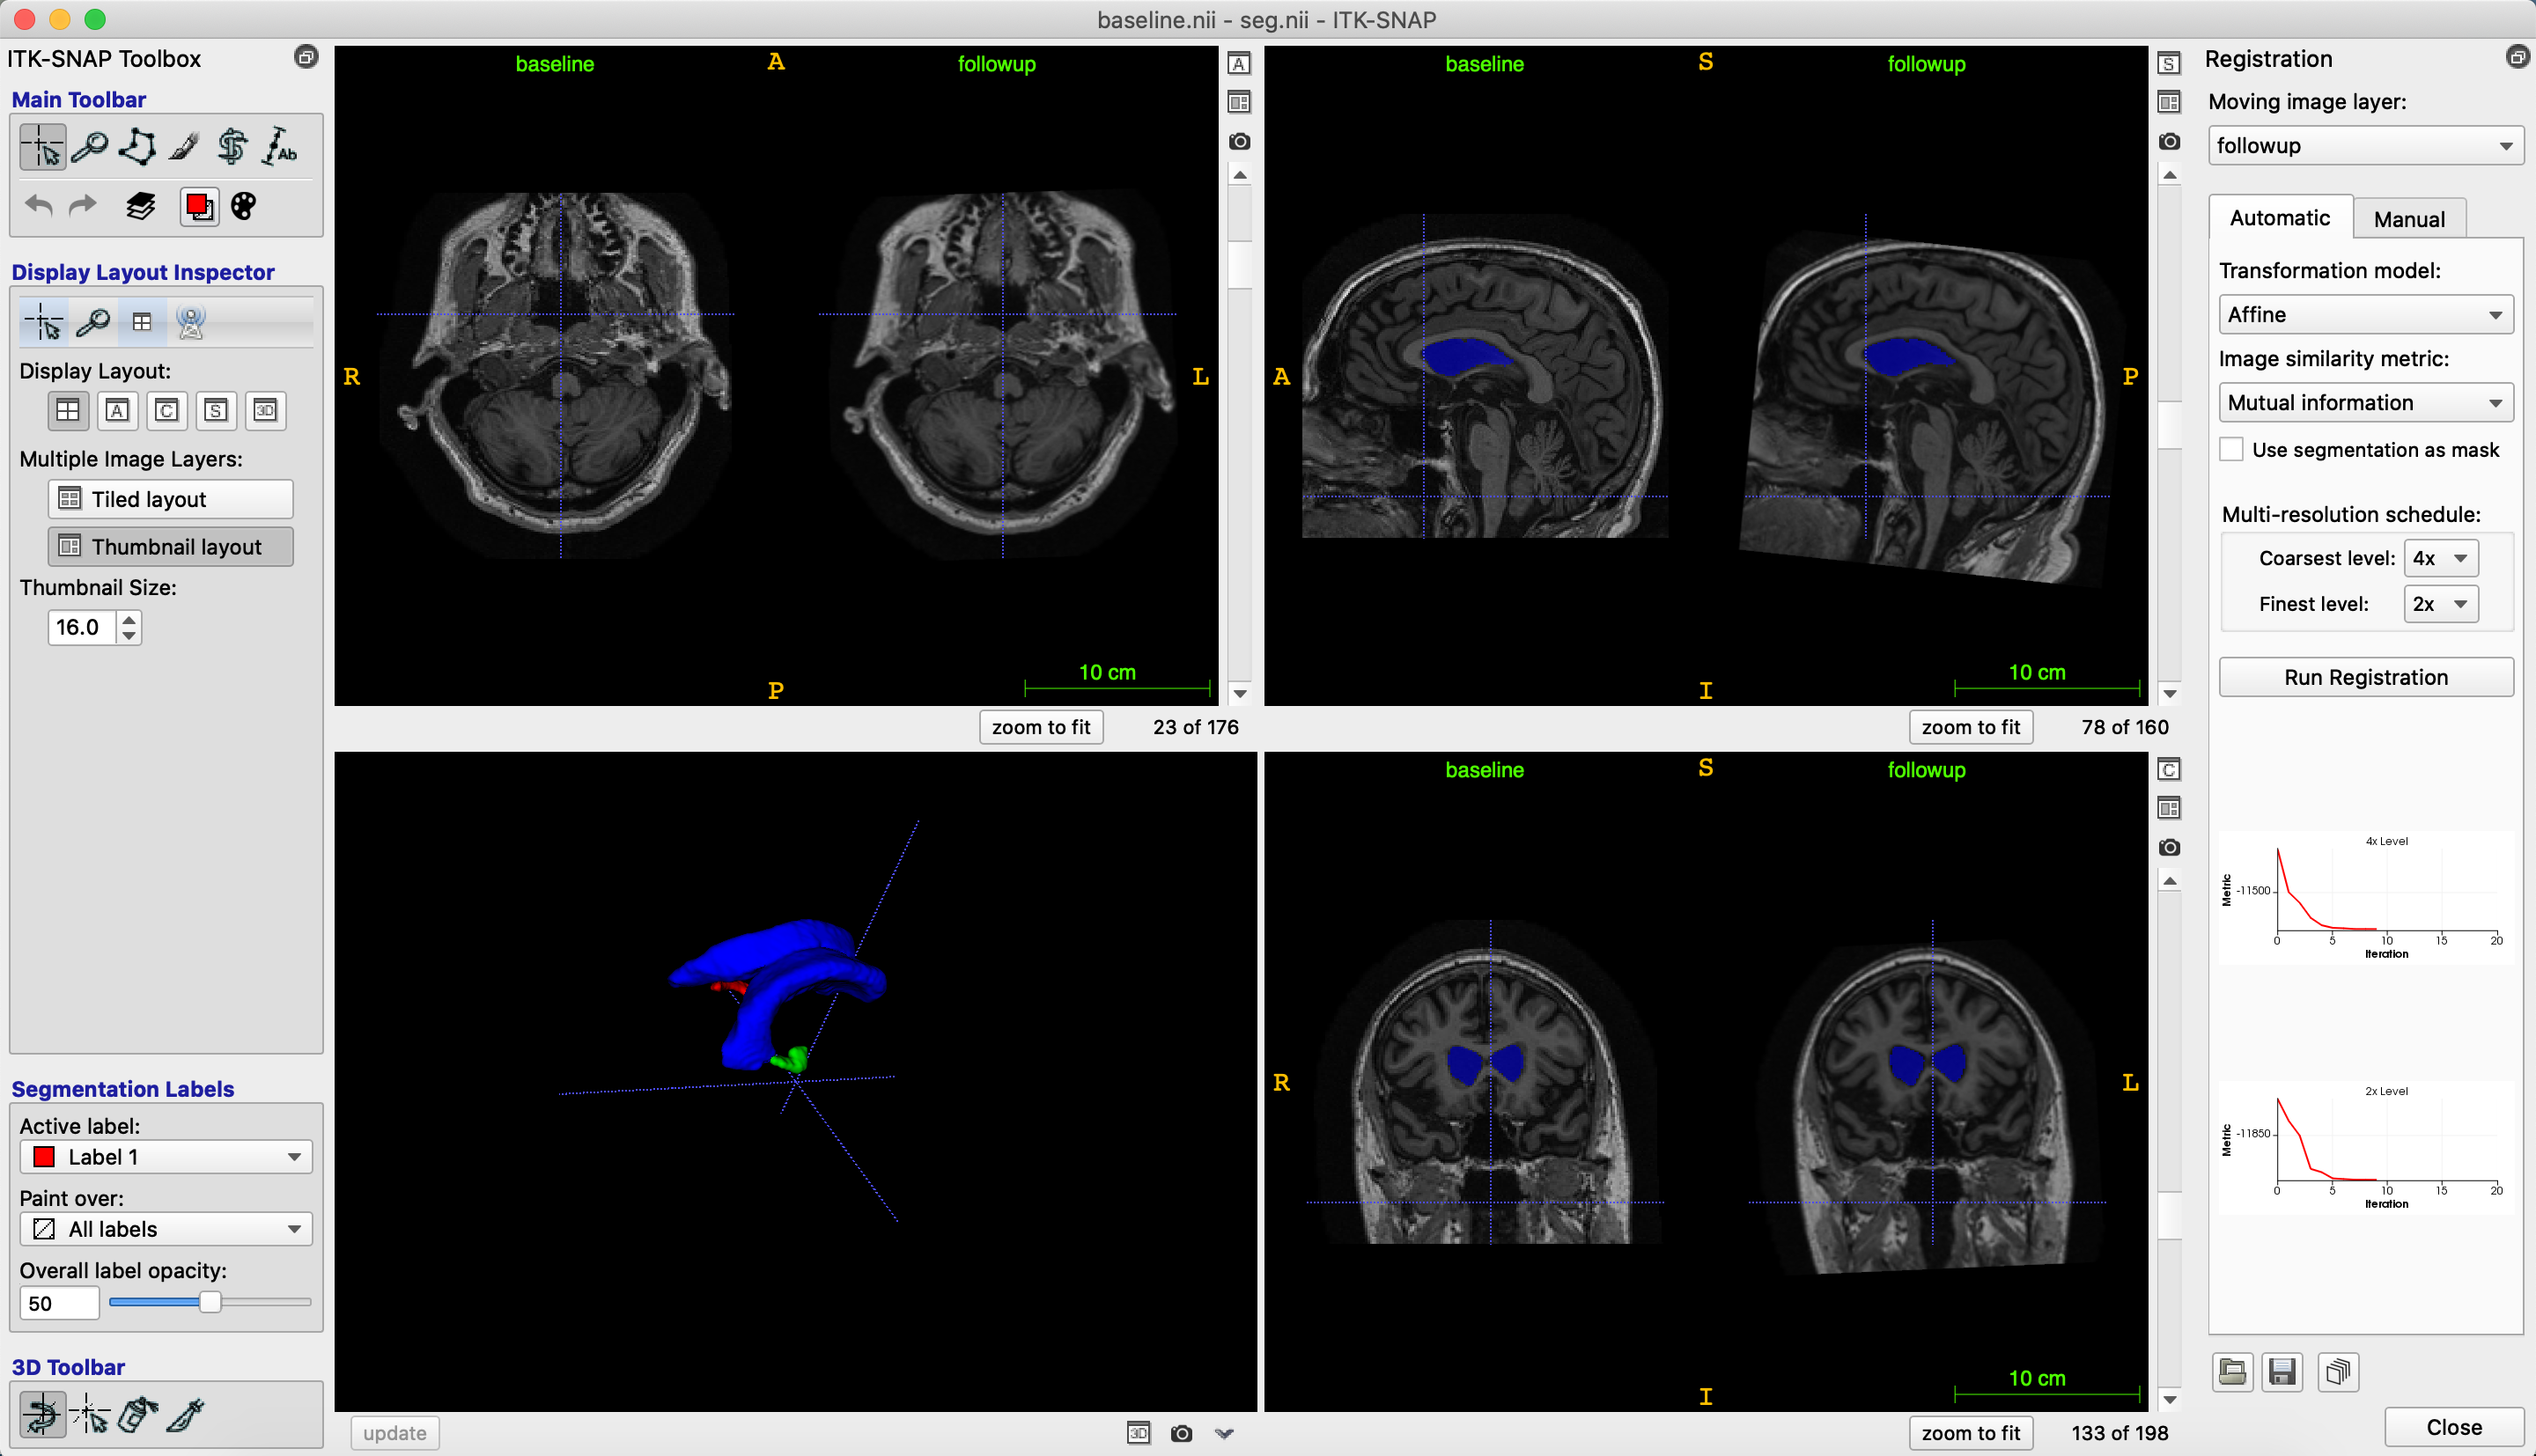

Affine transformation gives better registration than Rigid transformation because Affine transformation allows for scaling while Rigid transformation only rotates and translates the image. Different similarity matrics seem to give similar results under Affine transformation. Furthermore, automatic registration performs much better and takes much less time than manual registration, because the latter requires adjusting 3-D rotation, translation, and scaling manually.

## **3.4 ImageIO**

In [ ]:
def my_read_nifti(filename):
    """ 
    Read NIfTI image voxels and header
    :param filename: path to the image to read
    :returns: tuple (img,hdr) consisting of numpy voxel array and nibabel NIfTI header 
    """
    img = nib.load(filename)
    return img.get_fdata(), img.header
def my_write_nifti(filename, img, header = None): 
    """ Write NIfTI image voxels and header
    :param filename: path to the image to save
    :param img: numpy voxel array
    :param header: nibabel NIfTI header
    """
    if header is not None:
        nifti_img = nib.Nifti1Image(img, affine=header.get_best_affine(), header=header)
    else:
        nifti_img = nib.Nifti1Image(img, affine=np.ones((len(img.shape),1)))
    nib.save(nifti_img, filename)

In [ ]:
# Read images and headers from the baseline and followup files.
I_bl,hdr_bl = my_read_nifti(os.path.join(data_dir, 'baseline.nii'))
I_fu,hdr_fu = my_read_nifti(os.path.join(data_dir, 'followup.nii'))

## **3.5 3D Image Display** 

### **3.5.1 Deliverables**

In [ ]:
def my_view(img, title = None, header=None, xhair=None, crange=None, cmap='gray'): 
    """
    Display a 3D image in a layout similar to ITK-SNAP
    :param img: 3D voxel array
    :param header: Image header (returned by my_read_nifti)
    :param xhair: Crosshair position (1D array or tuple)
    :param crange: Intensity range, a tuple with minimum and maximum values 
    :param cmap: Colormap (a string, see matplotlib documentation)
    """
    if header != None:
        print(header)
    # Get the x, y, z dimensions of the img input
    x_dim = img.shape[0]
    y_dim = img.shape[1]
    z_dim = img.shape[2]
    # Create figure and subplots objects
    fig, axs = plt.subplots(2,2)
    # Assign the center of the ND img to crosshair
    if xhair == None:
      xhair = np.array([x_dim//2, y_dim//2, z_dim//2])
    if crange==None: #get the intensity of the image, range from 0-1713
      crange=(img.min(),img.max())
    # Plot the subplots and flip the x, y axes
    if x_dim == y_dim and y_dim == z_dim:
        aspect1 = None
        aspect2 = None
        aspect3 = None
    else:
        aspect1 = 1.003/1.205
        aspect2 = 0.9993/1.003
        aspect3 = 0.9993/1.205
    axs[0,0].imshow(img[:, :, xhair[2]].T, cmap = cmap, origin = 'lower', vmin=crange[0],vmax=crange[1],aspect=aspect1)
    axs[0,0].invert_xaxis()
    axs[0,0].axvline(xhair[0], c = '#ccffff')
    axs[0,0].axhline(xhair[1], c = '#ccffff')
    axs[0,1].imshow(img[xhair[0],:,:].T, cmap = cmap, origin = 'lower', vmin=crange[0],vmax=crange[1],aspect=aspect2)
    axs[0,1].invert_xaxis()
    axs[0,1].axvline(xhair[1], c = '#ccffff')
    axs[0,1].axhline(xhair[2], c = '#ccffff')
    im = axs[1,1].imshow(img[:,xhair[1],:].T, cmap = cmap, origin = 'lower', vmin=crange[0],vmax=crange[1],aspect=aspect3)
    axs[1,1].invert_xaxis()
    axs[1,1].axvline(xhair[0], c = '#ccffff')
    axs[1,1].axhline(xhair[2], c = '#ccffff')
    axs[1,0].axis('off')
    # Create the colorbar
    cax = plt.axes([0.175, 0.15, 0.3, 0.05])
    plt.colorbar(im, orientation='horizontal', ax=axs[0,0], cax=cax)
    plt.title(title)
    plt.show()

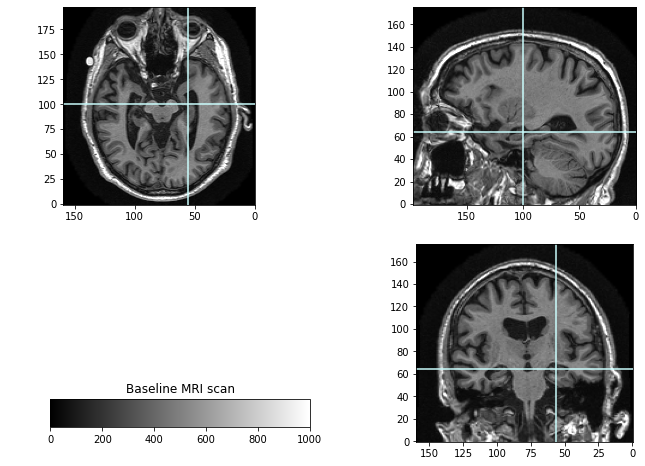

In [ ]:
my_view(I_bl,'Baseline MRI scan', xhair = [56, 100, 64], crange = (0,1000))

## **3.6 Apply Affine Transformations to 3D Image**

In [ ]:
def my_read_transform(filename):
    """
    Read Greedy-style 3D transform (4x4 matrix) from file
    :param filename: File name containing transform file
    :returns: tuple (A,b) where A is the 3x3 affine matrix, b is the translation vector
    """
    matrix = np.loadtxt(data_dir + filename)
    A = matrix[:matrix.shape[0] - 1, :matrix.shape[1]-1]
    b = matrix[:matrix.shape[0] - 1, matrix.shape[1]-1]
    return A, b

### **3.6.3 Deliverables**

In [ ]:
def my_transform_image(I_ref, I_mov, A, b, method='linear', fill_value=0): 
    """
    Transform a moving image into the space of the fixed image
    :param I_ref: 3D voxel array of the fixed (reference) image 
    :param I_mov: 3D voxel array of the moving image
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param method: Interpolation method (e.g., 'linear', 'nearest')
    :param fill_value: Value with which to replace missing values (e.g., 0) 
    """
    # Use meshgrid to find all coordinates of the fixed image
    x_ref = I_ref.shape[0]
    y_ref = I_ref.shape[1]
    z_ref = I_ref.shape[2]
    x_grid = np.linspace(0, x_ref-1, num=x_ref, endpoint=True)
    y_grid = np.linspace(0, y_ref-1, num=y_ref, endpoint=True)
    z_grid = np.linspace(0, z_ref-1, num=z_ref, endpoint=True)
    xv, yv, zv = np.meshgrid(x_grid, y_grid, z_grid, indexing='ij')

    # Apply Affine Trans matrix to find all transformed coordinates of the moving image 
    x_mov = A[0,0] * xv + A[0,1] * yv + A[0,2] * zv + b[0]
    y_mov= A[1,0] * xv + A[1,1] * yv + A[1,2] * zv + b[1]
    z_mov= A[2,0] * xv + A[2,1] * yv + A[2,2] * zv + b[2]

    # Interpolation
    trans_coor = np.zeros((x_ref,y_ref,z_ref,3)) # a matrix that stores the transformed position of every coordinate in I_ref
    trans_coor[:,:,:,0] = x_mov
    trans_coor[:,:,:,1] = y_mov
    trans_coor[:,:,:,2] = z_mov
    I_aff = interpn((x_grid, y_grid, z_grid), I_mov, trans_coor, method = method, bounds_error=False, fill_value = fill_value)

    return I_aff

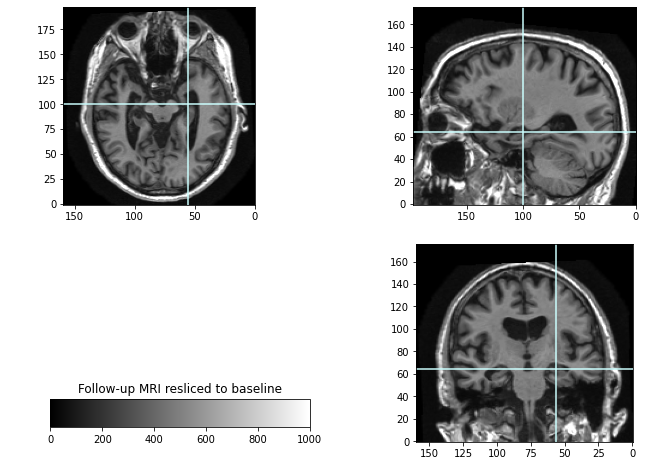

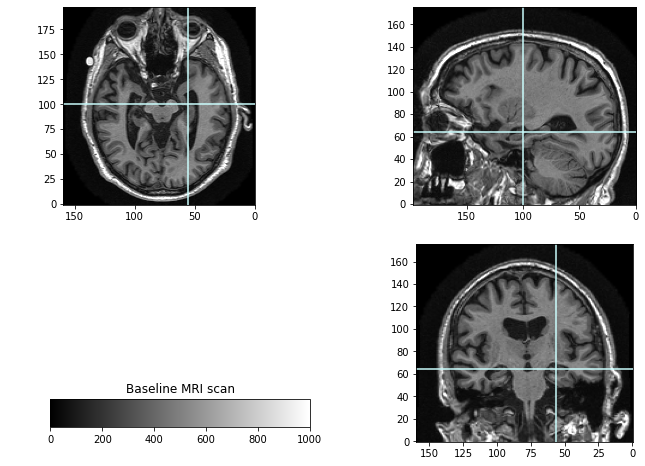

In [ ]:
A, b = my_read_transform('f2b.txt')
I_aff = my_transform_image(I_bl, I_fu, A, b)
my_view(I_aff,'Follow-up MRI resliced to baseline', xhair = [56,100,64],crange = (0,1000))
my_view(I_bl, 'Baseline MRI scan', xhair = [56,100,64],crange = (0,1000))

## **3.7 Examine the Effects of Low Pass Filtering on Difference Image Computation**

In [ ]:
I_delta = np.zeros((31,31,31))
I_delta[15,15,15] = 1
I_delta.shape

(31, 31, 31)

### **3.7.3.1 Deliverables**

In [ ]:
def my_gaussian_lpf(image, sigma):
    """
    Apply 3D Gaussian low-pass filtering to an image
    """
    # Construct a gaussian filter with sigma
    filter_size = int(2 * np.ceil(3.5*sigma) + 1)
    min_ind = int(-(filter_size//2))
    max_ind = int(filter_size//2)
    x = np.linspace(min_ind, max_ind, filter_size)
    y = np.linspace(min_ind, max_ind, filter_size)
    z = np.linspace(min_ind, max_ind, filter_size)
    xx, yy, zz = np.meshgrid(x,y,z, indexing = 'ij')
    gauss_xx = (1/(sigma * (2*np.pi)**(1/2))) * np.exp(-(np.square(xx)/(2*sigma**2)))
    gauss_yy = (1/(sigma * (2*np.pi)**(1/2))) * np.exp(-(np.square(yy)/(2*sigma**2)))
    gauss_zz = (1/(sigma * (2*np.pi)**(1/2))) * np.exp(-(np.square(zz)/(2*sigma**2)))
    gauss_filter = gauss_xx * gauss_yy * gauss_zz

    # convolve the gaussian filter with the FFT of the image
    img = signal.fftconvolve(image, gauss_filter, mode = 'same')
    return img

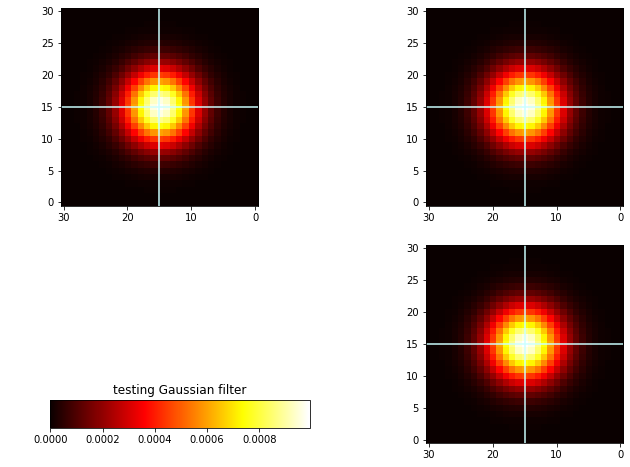

In [ ]:
I_delta_gaussian = my_gaussian_lpf(I_delta, 4)
my_view(I_delta_gaussian, title = 'testing Gaussian filter', xhair = [15,15,15], cmap = 'hot')

In [ ]:
def my_mean_lpf(image, radius):
    """Apply 3D mean filtering to an image"""
    filter_size = 2*radius + 1
    mean_filter = np.ones((filter_size, filter_size, filter_size))/(filter_size**3)
    img = signal.fftconvolve(image, mean_filter, mode = 'same')
    return img

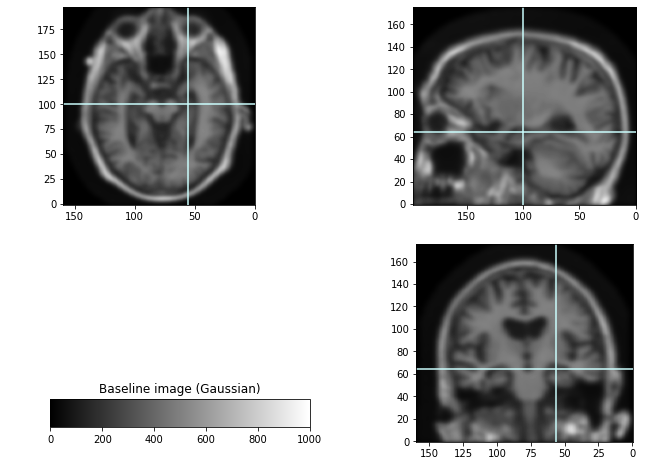

In [ ]:
# Baseline image with Gaussian filtering
I_bl_gaussian = my_gaussian_lpf(I_bl, sigma = 2)
my_view(I_bl_gaussian, 'Baseline image (Gaussian)', xhair = [56,100,64], crange = (0,1000))

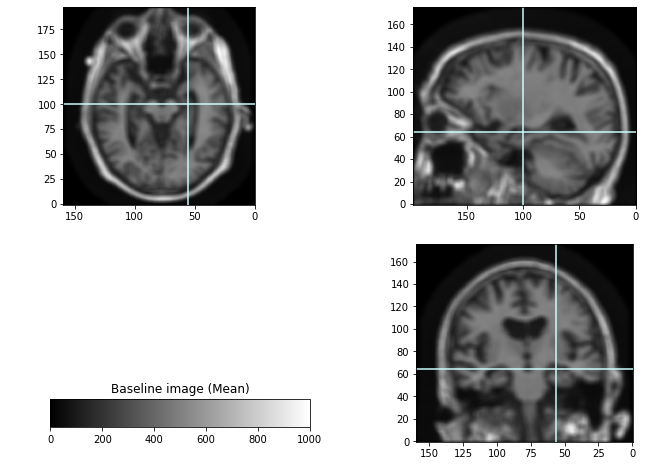

In [ ]:
# Baseline image with mean filtering
I_bl_mean = my_mean_lpf(I_bl, radius = 2)
my_view(I_bl_mean, 'Baseline image (Mean)', xhair = [56,100,64], crange = (0,1000))

In [ ]:
def difference_image(bl_img, fu_img, A, b, LPF = None, sigma = None, radius = None, method = None):
    """
    Calculate the difference images
    
    :param bl_img: 3D voxel array of the fixed (reference) image 
    :param fu_img: 3D voxel array of the follow-up image
    :param LPF: types of filtering schemes, Gaussian or Mean
    :param sigma: the sigma value for Gaussian filtering
    :param radiu: the radius value for Mean filtering
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param method: Interpolation method (e.g., 'linear', 'nearest')
    """
    if LPF == 'Gaussian':
        K_b = my_gaussian_lpf(bl_img, sigma)
        K_f = my_gaussian_lpf(fu_img, sigma)
    elif LPF == 'Mean':
        K_b = my_mean_lpf(bl_img, radius = radius)
        K_f = my_mean_lpf(fu_img, radius = radius)
    else:
        K_b = bl_img
        K_f = fu_img
    K_f = my_transform_image(K_b, K_f, A, b, method = method)
    return K_f - K_b

In [ ]:
cmap = 'jet'

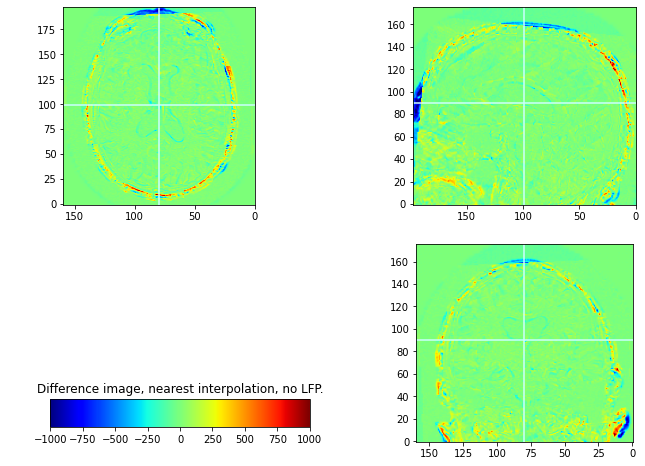

In [ ]:
# No filtering, Nearest Neighbor interpolation
diff_img = difference_image(I_bl, I_fu, A, b, method = 'nearest')
my_view(diff_img, title = 'Difference image, nearest interpolation, no LFP.', xhair = [80,99,90], cmap = cmap, crange=(-1000, 1000))

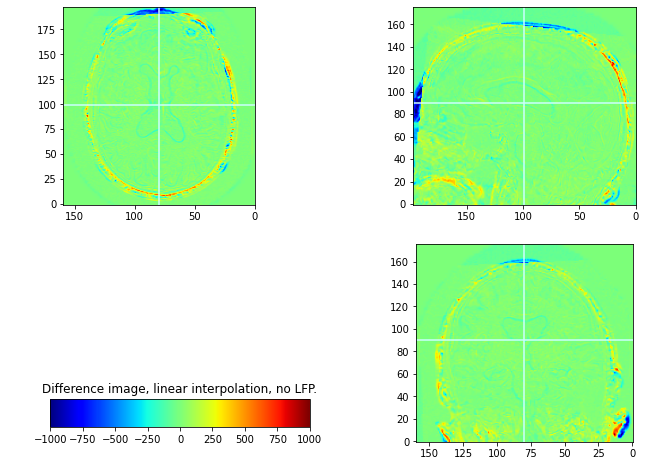

In [ ]:
# No filtering, linear interpolation
diff_img = difference_image(I_bl, I_fu, A, b, method = 'linear')
my_view(diff_img, title = 'Difference image, linear interpolation, no LFP.', xhair = [80,99,90], cmap = cmap, crange = (-1000,1000))

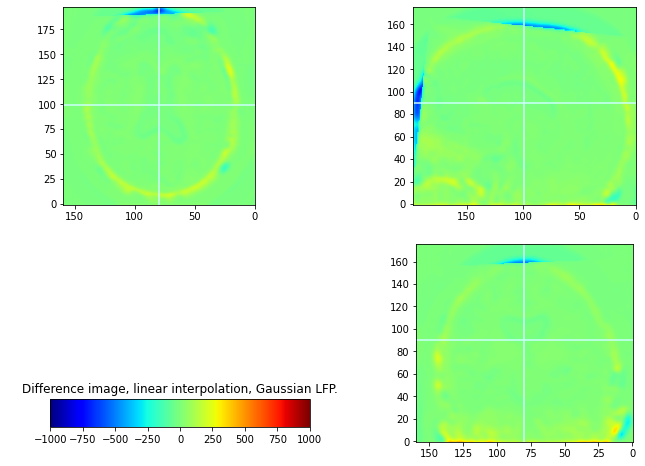

In [ ]:
# Gaussian LPF, linear interpolation
diff_img = difference_image(I_bl, I_fu, A, b, LPF = 'Gaussian', sigma = 2, method = 'linear')
my_view(diff_img, title = 'Difference image, linear interpolation, Gaussian LFP.', xhair = [80,99,90], cmap = cmap, crange = (-1000,1000))

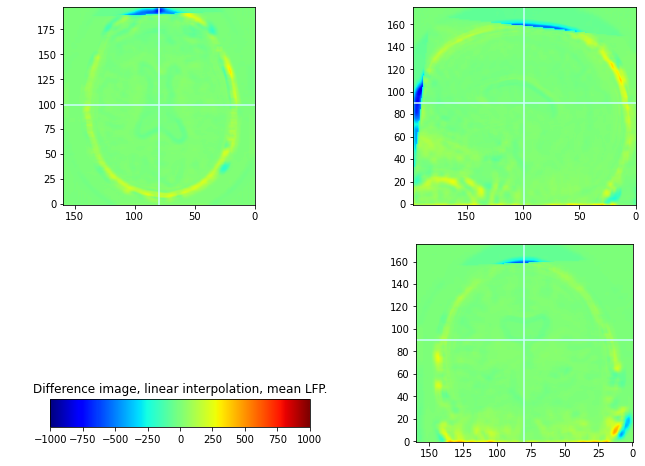

In [ ]:
# Mean LPF, linear interpolation
diff_img = difference_image(I_bl, I_fu, A, b, LPF = 'Mean', radius = 2, method = 'linear')
my_view(diff_img, title = 'Difference image, linear interpolation, mean LFP.', xhair = [80,99,90], cmap = cmap, crange = (-1000,1000))

### **3.7.4 Deliverables**

In [ ]:
# Import segmentation image
I_seg, hdr_seg = my_read_nifti(os.path.join(data_dir, 'seg.nii'))
I_seg.shape

(160, 198, 176)

In [ ]:
def my_rms_over_roi(image, seg, label):
    
    """Compute RMS of a difference image over a label in the segmentation"""
    
    # Get the index of the input label in seg.
    label_ind = seg == label
    # Get the array containing all voxels with that label
    image_with_label = image[label_ind]

    return np.sqrt(np.sum(image_with_label ** 2)/len(image_with_label))

In [ ]:
# Function that plots RMS intensity difference

def plot_rms(bl_img, fu_img, A, b, min, max, seg, filter = None):

    """
    Plot the RMS intensity of the difference images
    :param bl_img: 3D voxel array of the fixed (reference) image 
    :param fu_img: 3D voxel array of the follow-up image
    :param filter: types of filtering schemes, Gaussian or Mean
    :param A: 3x3 affine transformation matrix
    :param b: 3x1 translation vector
    :param min: the min value of the parameter corresponding to the filter
    :param max: the max value of the parameter corresponding to the filter
    :param seg: the segmentation image with region of interest labels
    """
    params = []
    rms1_list = []
    rms2_list = []
    rms3_list = []
    if filter == 'Gaussian':
        param = 'Sigma'
        for sigma in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]:
            params.append(sigma)
            diff_img = difference_image(bl_img, fu_img, A, b, LPF = filter, sigma = sigma, method = 'linear')
            rms1 = my_rms_over_roi(diff_img, seg, 1)
            rms2 = my_rms_over_roi(diff_img, seg, 2)
            rms3 = my_rms_over_roi(diff_img, seg, 3)
            rms1_list.append(rms1)
            rms2_list.append(rms2)
            rms3_list.append(rms3)
    
    elif filter == 'Mean':
        param = 'Radius'
        for radius in range(min, max + 1, 1):
            params.append(radius)
            diff_img = difference_image(bl_img, fu_img, A, b, LPF = filter, radius = radius, method = 'linear')
            rms1 = my_rms_over_roi(diff_img, seg, 1)
            rms2 = my_rms_over_roi(diff_img, seg, 2)
            rms3 = my_rms_over_roi(diff_img, seg, 3)
            rms1_list.append(rms1)
            rms2_list.append(rms2)
            rms3_list.append(rms3)
    
    plt.figure()
    plt.plot(params, rms1_list)
    plt.plot(params, rms2_list)
    plt.plot(params, rms3_list)
    plt.title('RMS intensity difference ' + filter)
    plt.xlabel(param)
    plt.ylabel('RMS intensity difference')
    plt.legend(['label 1', 'label 2', 'label 3'])
    plt.show()

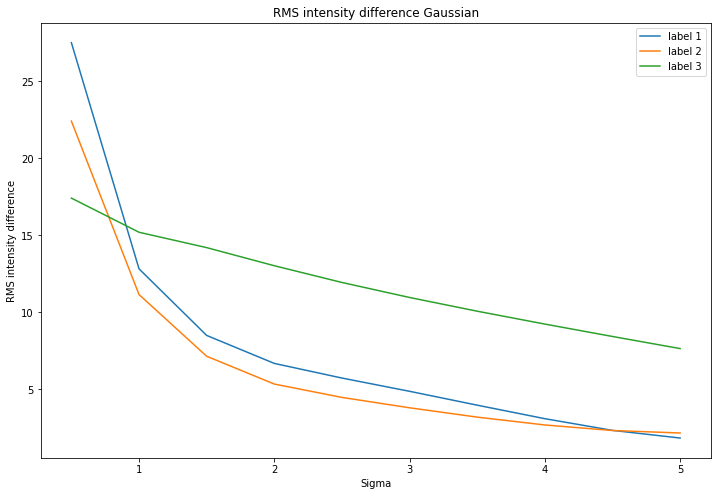

In [ ]:
plot_rms(I_bl, I_fu, A, b, 0.5,5,I_seg, filter = 'Gaussian')

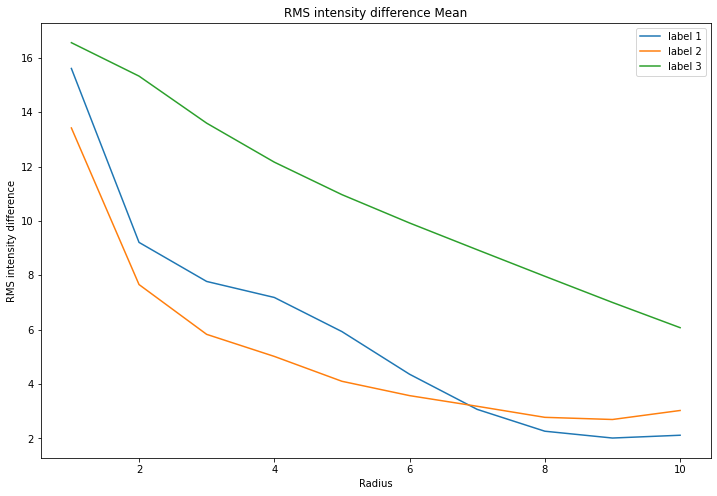

In [ ]:
plot_rms(I_bl, I_fu, A, b, 1,10,I_seg, filter = 'Mean')

For both the Gaussian filter and the Mean filter, when the parameters (sigma and radius, respectively) increased, the RMS intensity differences of all three labels decreased. When the filter size is larger, the weighted average of the intensity of a given voxel is smoothed over a larger number of nearby voxels and therefore captures more spatial features of the nearby region of the original image. Therefore, the RMS intensity difference between the filtered image with larger kernel sizes and the original image would be smaller.

## **3.8 Affine Transformations and Affine Registration with PyTorch**

In [ ]:
import torch
import torch.nn.functional as tfun

In [ ]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### **3.8.1.1 Deliverables**

In [ ]:
T_bl = torch.from_numpy(I_bl).unsqueeze(0).unsqueeze(0)
print(T_bl.shape)
print(I_bl.shape)

torch.Size([1, 1, 160, 198, 176])
(160, 198, 176)


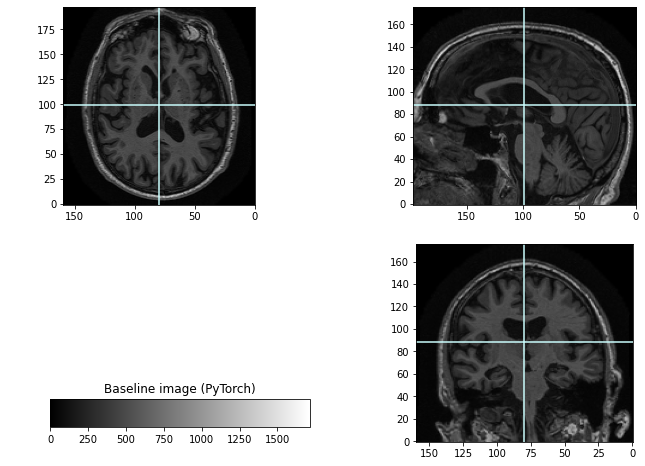

In [ ]:
my_view(T_bl.squeeze().detach().cpu().numpy(), title = 'Baseline image (PyTorch)',  cmap='gray')

### **3.8.2.3 Deliverables**

In [ ]:
def my_numpy_affine_to_pytorch_affine(A, b, img_size): 
    """
    Convert affine transform (A,b) from NumPy to PyTorch coordinates
    :param A: affine matrix, represented as a shape (3,3) NumPy array 
    :param b: translation vector, represented as a shape (3) NumPy array
    :returns: tuple of NumPy arrays (A',b') holding affine transform in PyTorch coords 
    """
    Sx = img_size[0]
    Sy = img_size[1]
    Sz = img_size[2]
    W = np.array([[0,0,2/Sz],[0,2/Sy,0],[2/Sx,0,0]])
    z = np.array([1/Sz-1, 1/Sy-1, 1/Sx-1])
    W_inv = np.linalg.inv(W)
    A_prime = W@A@W_inv
    x = np.array([26,28,31])
    b_prime = W@(A@x+b) + z - A_prime@(W@x + z)

    return A_prime, b_prime
    


def my_pytorch_affine_to_numpy_affine(A_prime, b_prime, img_size): 
    """
    Convert affine transform (A,b) from PyTorch to NumPy coordinates
    :param A: affine matrix, represented as a shape (3,3) NumPy array
    :param b: translation vector, represented as a shape (3)NumPy array
    :returns: tuple of NumPy arrays (A',b') holding affine transform in NumPy coords 
    """

    Sx = img_size[0]
    Sy = img_size[1]
    Sz = img_size[2]
    W = np.array([[0,0,2/Sz],[0,2/Sy,0],[2/Sx,0,0]])
    z = np.array([1/Sz-1, 1/Sy-1, 1/Sx-1])
    W_inv = np.linalg.inv(W)
    A = W_inv@A_prime@W
    x = np.array([45,78,99])
    b = W_inv@(A_prime@(W@x + z) + b_prime - z - W@A@x)

    return A, b

In [ ]:
 A_prime, b_prime = my_numpy_affine_to_pytorch_affine(A, b, I_bl.shape) 
 A_prime, b_prime

(array([[ 0.9939    , -0.120375  ,  0.04881818],
        [ 0.08791111,  1.001     ,  0.03361616],
        [-0.04499   , -0.0314325 ,  1.0003    ]]),
 array([ 0.18924318,  0.06270253, -0.00460125]))

In [ ]:
 A_test, b_test = my_pytorch_affine_to_numpy_affine(A_prime, b_prime, I_bl.shape) 
 A_test, b_test

(array([[ 1.0003, -0.0254, -0.0409],
        [ 0.0416,  1.001 ,  0.0989],
        [ 0.0537, -0.107 ,  0.9939]]), array([ 5.6887, -5.8519, 23.4575]))

In [ ]:
from torch.nn.functional import affine_grid, grid_sample

In [ ]:
def my_transform_image_pytorch(T_ref, T_mov, T_A, T_b, mode='bilinear', padding_mode='zeros'):
    """
    Apply an affine transform to 3D images represented as PyTorch tensors
    :param T_ref: Fixed (reference) image, represented as a 5D tensor
    :param T_mov: Moving image, represented as a 5D tensor
    :param T_A: affine matrix in PyTorch coordinate space, represented as a shape (3,3) tensor 
    :param T_b: translation vector in PyTorch coordinate space, represented as a shape (3) tensor
    :param mode: Interpolation mode, see grid_sample
    :param padding_mode: Padding mode, see grid_sample
    :returns: Transformed moving image, represented as a 5D tensor 
    """

    b = T_b.reshape(3,-1)
    A = torch.cat((T_A, b), 1).unsqueeze(0)
    affine_coord = affine_grid(A, T_ref.shape, align_corners = False)
    # affine_coord[:,:,:,:,0] = T_A[0,0] * affine_coord[:,:,:,:,0] + T_A[0,1] * affine_coord[:,:,:,:,1] + T_A[0,2] * affine_coord[:,:,:,:,2] + T_b[0]
    # affine_coord[:,:,:,:,1] = T_A[1,0] * affine_coord[:,:,:,:,0] + T_A[1,1] * affine_coord[:,:,:,:,1] + T_A[1,2] * affine_coord[:,:,:,:,2] + T_b[1]
    # affine_coord[:,:,:,:,2] = T_A[2,0] * affine_coord[:,:,:,:,0] + T_A[2,1] * affine_coord[:,:,:,:,1] + T_A[2,2] * affine_coord[:,:,:,:,2] + T_b[2]
    #T_mov = T_mov.type(torch.float)
    I_aff = grid_sample(T_mov, affine_coord, mode = mode, padding_mode = padding_mode, align_corners = False)

    return I_aff

RMS over label 1 is 0.000000
RMS over label 2 is 0.000000
RMS over label 3 is 0.000000


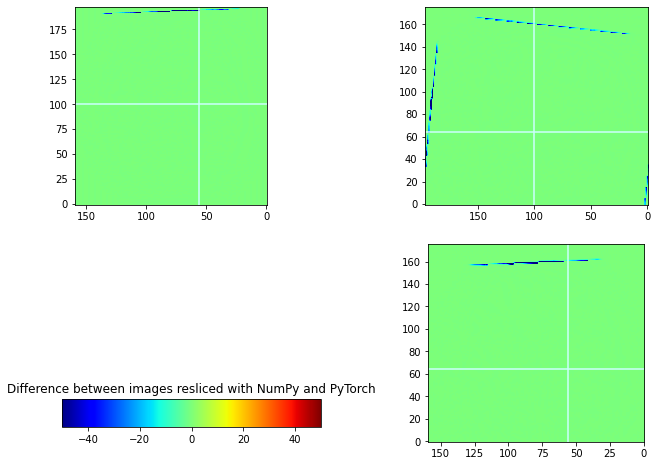

In [ ]:
# Convert the affine transform (A,b) to a PyTorch affine transform
A_prime, b_prime = my_numpy_affine_to_pytorch_affine(A, b, I_bl.shape) 
T_A, T_b = torch.tensor(A_prime), torch.tensor(b_prime)

# Convert the baseline and follow-up images to PyTorch tensors
T_bl = torch.from_numpy(I_bl).unsqueeze(0).unsqueeze(0) 
T_fu = torch.from_numpy(I_fu).unsqueeze(0).unsqueeze(0)

# Apply the transform to the follow-up image using PyTorch
T_fu_reslice = my_transform_image_pytorch(T_bl, T_fu, T_A, T_b) 

# Apply the transform to the follow-up image using NumPy
I_fu_reslice = my_transform_image(I_bl, I_fu, A, b)

# Compute the difference between two ways of resampling
I_diff = I_fu_reslice - T_fu_reslice.squeeze().detach().cpu().numpy()

# Compute RMS difference between interpolated images over our labels
for label in (1,2,3):
    print('RMS over label %d is %f' % (label, my_rms_over_roi(I_diff, I_seg, label)))

# Visualize the difference image
my_view(I_diff, title = 'Difference between images resliced with NumPy and PyTorch', xhair=(56,100,64), crange=[-50,50], cmap='jet') 
#plt.title(title = 'Difference between images \\ resliced with NumPy and PyTorch')

### **3.8.3.3 Deliverables**

**Regular LBFGS optimization**

In [ ]:
def my_affine_objective_fn(T_ref, T_mov, T_A, T_b): 
    """
    Compute the affine registration objective function
    :param T_ref: Fixed (reference) image, represented as a 5D tensor
    :param T_mov: Moving image, represented as a 5D tensor
    :param T_A: affine matrix in PyTorch coordinate space, represented as a shape (3,3) tensor 
    :param T_b: translation vector in PyTorch coordinate space, represented as a shape (3) tensor 
    :returns: RMS difference between the reference image and transformed moving image
    """
    T_mov_reslice = my_transform_image_pytorch(T_ref, T_mov, T_A, T_b) 
    T_diff = T_ref - T_mov_reslice

    shape = T_diff.shape
    voxel_count = shape[0] * shape[1] * shape[2] * shape[3] * shape[4]
    rms = torch.sqrt(torch.sum(T_diff ** 2)/voxel_count)
    return rms

In [ ]:
my_affine_objective_fn(T_bl, T_fu, T_A, T_b)

tensor(87.0636, dtype=torch.float64)

In [ ]:
# Create tensors T_A and T_b and track their partial derivatives
T_A = torch.tensor(A_prime, requires_grad=True) 
T_b = torch.tensor(b_prime, requires_grad=True)
# Compute the objective function (forward pass)
obj = my_affine_objective_fn(T_bl, T_fu, T_A, T_b)
# Compute the partial derivatives of the objective function with respect to 
# elements of T_A and T_b automatically (backward pass)
obj.backward()
# Print the objective function value and partial derivatives
obj, T_A.grad, T_b.grad

(tensor(87.0636, dtype=torch.float64, grad_fn=<SqrtBackward>),
 tensor([[-14.9968, -78.1993,  29.2888],
         [ 53.0497, 164.1846,   3.7831],
         [-37.4488,  42.8693, -68.0847]], dtype=torch.float64),
 tensor([ 105.6461, -576.2125,  329.4407], dtype=torch.float64))

In [ ]:
# Starting point for optimization - identity affine transform. Note that 
# the LBFGS implementation in PyTorch requires all the parameters (i.e. 
# variables that we are optimizing over) to be contained in a single
# tensor, which we call T_opt
T_opt = torch.tensor(np.eye(4,4), requires_grad=True)

# Objective function for optimization, a wrapper around my_affine_objective_fn
f_opt = lambda : my_affine_objective_fn(T_bl, T_fu, T_opt[0:3,0:3], T_opt[0:3,3])

# Initialize the LBFGS optimizer with a line search routine
optimizer = torch.optim.LBFGS([T_opt], history_size=10, max_iter=4, line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history = []

# Run for a few iterations
for i in range(50):
    optimizer.zero_grad()
    objective = f_opt()
    objective.backward()
    optimizer.step(f_opt) 
    opt_history.append(objective.item())
    print('Iter %03d Obj %8.4f' % (i, objective.item()))

Iter 000 Obj 257.0808
Iter 001 Obj 248.9136
Iter 002 Obj 198.7524
Iter 003 Obj 194.2972
Iter 004 Obj 168.7945
Iter 005 Obj 159.5642
Iter 006 Obj 155.9805
Iter 007 Obj 153.1526
Iter 008 Obj 147.0970
Iter 009 Obj 137.9407
Iter 010 Obj 128.8486
Iter 011 Obj 120.1587
Iter 012 Obj 100.1255
Iter 013 Obj  96.2984
Iter 014 Obj  94.1449
Iter 015 Obj  93.6140
Iter 016 Obj  89.6552
Iter 017 Obj  89.6066
Iter 018 Obj  87.8507
Iter 019 Obj  87.8384
Iter 020 Obj  86.9673
Iter 021 Obj  86.7566
Iter 022 Obj  86.6439
Iter 023 Obj  86.4414
Iter 024 Obj  86.4288
Iter 025 Obj  86.4258
Iter 026 Obj  86.4248
Iter 027 Obj  86.4242
Iter 028 Obj  86.4236
Iter 029 Obj  86.4235
Iter 030 Obj  86.4234
Iter 031 Obj  86.4234
Iter 032 Obj  86.4234
Iter 033 Obj  86.4234
Iter 034 Obj  86.4234
Iter 035 Obj  86.4234
Iter 036 Obj  86.4234
Iter 037 Obj  86.4234
Iter 038 Obj  86.4234
Iter 039 Obj  86.4234
Iter 040 Obj  86.4234
Iter 041 Obj  86.4234
Iter 042 Obj  86.4234
Iter 043 Obj  86.4234
Iter 044 Obj  86.4234
Iter 045 O

In [ ]:
#Plot of the resliced moving image after registration

A_prime_opt = T_opt[0:3, 0:3]
b_prime_opt = T_opt[0:3, 3]
A_prime_opt,  b_prime_opt

(tensor([[ 0.9942, -0.1207,  0.0486],
         [ 0.0884,  1.0002,  0.0342],
         [-0.0450, -0.0318,  1.0011]], dtype=torch.float64,
        grad_fn=<SliceBackward>),
 tensor([ 0.1888,  0.0642, -0.0053], dtype=torch.float64,
        grad_fn=<SelectBackward>))

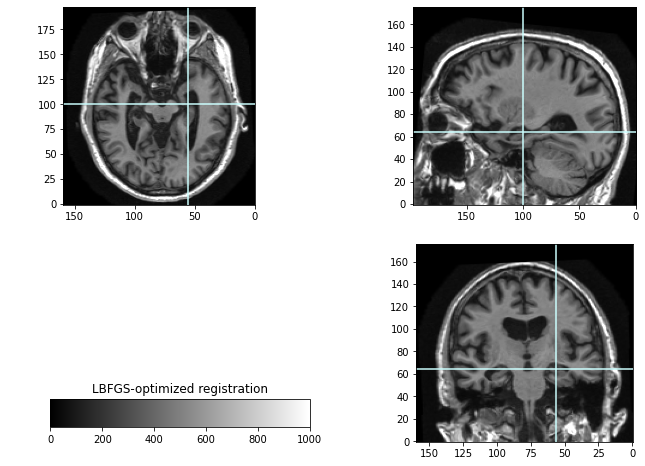

In [ ]:
T_fu_reslice = my_transform_image_pytorch(T_bl, T_fu, A_prime_opt, b_prime_opt) 
T_fu_reslice = T_fu_reslice.squeeze().detach().cpu().numpy()
my_view(T_fu_reslice, title = 'LBFGS-optimized registration', xhair=(56,100,64), crange = (0,1000))

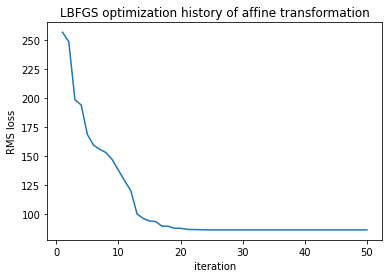

In [ ]:
# Plot of opt_history showing the change in objective function over iteration of the optimization algorithm

plt.figure()
plt.plot(np.arange(1, 51), opt_history)
plt.title('LBFGS optimization history of affine transformation')
plt.xlabel('iteration')
plt.ylabel('RMS loss')
plt.show()

In [ ]:
# Optimal affine transform converted to the NumPy coordinate system

A_prime_opt = A_prime_opt.detach().numpy()
b_prime_opt = b_prime_opt.detach().numpy()
A_prime_opt_np, b_prime_opt_np =my_pytorch_affine_to_numpy_affine(A_prime_opt, b_prime_opt, I_bl.shape)
print('LBFGS: ', A_prime_opt_np, b_prime_opt_np)
print()
print('ITK-SNAP: ', A, b)

LBFGS:  [[ 1.0010532  -0.02573538 -0.04094661]
 [ 0.04238363  1.00019643  0.09941291]
 [ 0.05351431 -0.10724933  0.9941696 ]] [ 5.61159992 -5.73519857 23.43571665]

ITK-SNAP:  [[ 1.0003 -0.0254 -0.0409]
 [ 0.0416  1.001   0.0989]
 [ 0.0537 -0.107   0.9939]] [ 5.6887 -5.8519 23.4575]


**LBFGS optimization with Gaussian filter**

Iter (Gaussian) 000 Obj 109.5962
Iter (Gaussian) 001 Obj  78.7988
Iter (Gaussian) 002 Obj  63.7485
Iter (Gaussian) 003 Obj  63.6258
Iter (Gaussian) 004 Obj  53.4808
Iter (Gaussian) 005 Obj  50.7658
Iter (Gaussian) 006 Obj  46.0944
Iter (Gaussian) 007 Obj  45.1846
Iter (Gaussian) 008 Obj  43.1577
Iter (Gaussian) 009 Obj  42.6934
Iter (Gaussian) 010 Obj  42.6161
Iter (Gaussian) 011 Obj  42.5560
Iter (Gaussian) 012 Obj  42.5394
Iter (Gaussian) 013 Obj  42.4943
Iter (Gaussian) 014 Obj  42.4765
Iter (Gaussian) 015 Obj  42.4746
Iter (Gaussian) 016 Obj  42.4734
Iter (Gaussian) 017 Obj  42.4733
Iter (Gaussian) 018 Obj  42.4733
Iter (Gaussian) 019 Obj  42.4733
Iter (Gaussian) 020 Obj  42.4733
Iter (Gaussian) 021 Obj  42.4733
Iter (Gaussian) 022 Obj  42.4733
Iter (Gaussian) 023 Obj  42.4733
Iter (Gaussian) 024 Obj  42.4733
Iter (Gaussian) 025 Obj  42.4733
Iter (Gaussian) 026 Obj  42.4733
Iter (Gaussian) 027 Obj  42.4733
Iter (Gaussian) 028 Obj  42.4733
Iter (Gaussian) 029 Obj  42.4733
Iter (Gaus

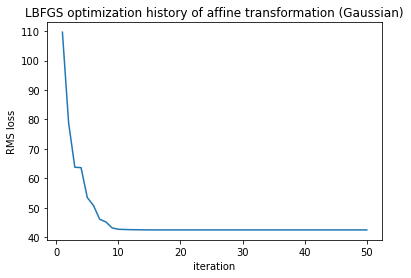

In [ ]:
'''
Apply Gaussian filter to baseline image and follow-up image before optimization.
'''

I_bl_gaussian = my_gaussian_lpf(I_bl, sigma = 5)
I_fu_gaussian = my_gaussian_lpf(I_fu, sigma = 5)


# Convert the affine transform (A,b) to a PyTorch affine transform
A_prime_gaussian, b_prime_gaussian = my_numpy_affine_to_pytorch_affine(A, b, I_bl_gaussian.shape) 
T_A_gaussian, T_b_gaussian = torch.tensor(A_prime_gaussian), torch.tensor(b_prime_gaussian)

# Convert the baseline and follow-up images to PyTorch tensors
T_bl_gaussian = torch.from_numpy(I_bl_gaussian).unsqueeze(0).unsqueeze(0) 
T_fu_gaussian = torch.from_numpy(I_fu_gaussian).unsqueeze(0).unsqueeze(0)

# Starting point for optimization - identity affine transform. Note that 
# the LBFGS implementation in PyTorch requires all the parameters (i.e. 
# variables that we are optimizing over) to be contained in a single
# tensor, which we call T_opt
T_opt_gaussian = torch.tensor(np.eye(4,4), requires_grad=True)

# Objective function for optimization, a wrapper around my_affine_objective_fn
f_opt_gaussian = lambda : my_affine_objective_fn(T_bl_gaussian, T_fu_gaussian, T_opt_gaussian[0:3,0:3], T_opt_gaussian[0:3,3])

# Initialize the LBFGS optimizer with a line search routine
optimizer_gaussian = torch.optim.LBFGS([T_opt_gaussian], history_size=10, max_iter=4, line_search_fn="strong_wolfe")

# Keep track of the objective function values over the course of optimization
opt_history_gaussian = []

# Run for a few iterations
for i in range(50):
    optimizer_gaussian.zero_grad()
    objective_gaussian = f_opt_gaussian()
    objective_gaussian.backward()
    optimizer_gaussian.step(f_opt_gaussian) 
    opt_history_gaussian.append(objective_gaussian.item())
    print('Iter (Gaussian) %03d Obj %8.4f' % (i, objective_gaussian.item()))

# opt_history
plt.figure()
plt.plot(np.arange(1, 51), opt_history_gaussian)
plt.title('LBFGS optimization history of affine transformation (Gaussian)')
plt.xlabel('iteration')
plt.ylabel('RMS loss')
plt.show()

In [ ]:
# Optimal affine transform (Gaussian) ()converted to the NumPy coordinate system

A_prime_opt_gaussian = T_opt_gaussian[0:3, 0:3].detach().numpy()
b_prime_opt_gaussian = T_opt_gaussian[0:3, 3].detach().numpy()

A_prime_opt_gaussian_np, b_prime_opt_gaussian_np =my_pytorch_affine_to_numpy_affine(A_prime_opt_gaussian, b_prime_opt_gaussian, I_bl.shape)
print('LBFGS: ', A_prime_opt_np, b_prime_opt_np)
print()
print('LBFGS, Gaussian: ', A_prime_opt_gaussian_np, b_prime_opt_gaussian_np)
print()
print('ITK-SNAP: ', A, b)

LBFGS:  [[ 1.0010532  -0.02573538 -0.04094661]
 [ 0.04238363  1.00019643  0.09941291]
 [ 0.05351431 -0.10724933  0.9941696 ]] [ 5.61159992 -5.73519857 23.43571665]

LBFGS, Gaussian:  [[ 1.01906419 -0.02298884 -0.04863893]
 [ 0.03708378  1.0063573   0.08491392]
 [ 0.06316663 -0.11051335  0.97133732]] [ 4.52638355 -5.44742271 25.45119375]

ITK-SNAP:  [[ 1.0003 -0.0254 -0.0409]
 [ 0.0416  1.001   0.0989]
 [ 0.0537 -0.107   0.9939]] [ 5.6887 -5.8519 23.4575]


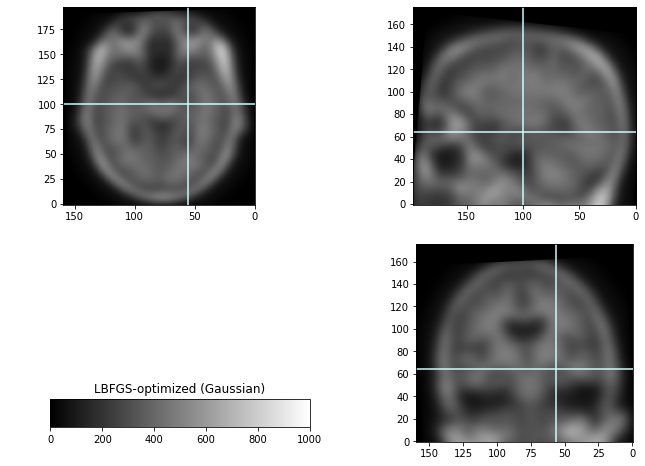

In [ ]:
# Plot of the resliced moving image after registration (Gaussian)

T_fu_reslice_gaussian = my_transform_image_pytorch(T_bl_gaussian, T_fu_gaussian, T_opt_gaussian[0:3, 0:3], T_opt_gaussian[0:3, 3]) 
T_fu_reslice_gaussian = T_fu_reslice_gaussian.squeeze().detach().cpu().numpy()
my_view(T_fu_reslice_gaussian, title = 'LBFGS-optimized (Gaussian)', xhair=(56,100,64), crange = (0,1000))

As observed in the plot, the optimization after appling a Gaussian filter did converge faster than optimization with regular image because the Gaussian filter made the baseline and followup images blurred and thus more similar, andt therefore it would require less computation of the gradients to find the optimal loss. The comparison among all three affine registration matrices showed that the matrix calculated with a Gaussian filter was still very similar to the other two matrices.